# Step.2 KGB(known Good/Bad)训练，用于检测拒绝集(训练集中的unknown标签)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import atecml.data
from tqdm import tqdm

class BasicModel(object):
    """Parent class of basic models"""
    def train(self, x_train, y_train, x_val, y_val):
        """return a trained model and eval metric o validation data"""
        pass
    
    def predict(self, model, x_test):
        """return the predicted result"""
        pass
    
    def get_oof(self, x_train, y_train, x_test, n_folds = 5):
        """K-fold stacking"""
        num_train, num_test = x_train.shape[0], x_test.shape[0]
        oof_train = np.zeros((num_train,)) 
        oof_test = np.zeros((num_test,))
        oof_test_all_fold = np.zeros((num_test, n_folds))
        aucs = []
        model_list = []
        
        for i in range(0,n_folds):
            
            val_index = DateFold[5] #始终用最后20%验证            
            train_index = list(all_list - DateFold[i])
                            
            print('{0} fold, train {1}, val {2}'.format(i, len(train_index), len(val_index)))
            x_tra, y_tra = x_train[train_index], y_train[train_index]
            x_val, y_val = x_train[val_index], y_train[val_index]
            
            #Over_sample
            #X_resampled, y_resampled = SMOTE().fit_sample(x_tra,y_tra)
            #model, auc = self.train(X_resampled, y_resampled, x_val, y_val)
            model, auc = self.train(x_tra, y_tra, x_val, y_val)
            aucs.append(auc)
            model_list.append(model)
            oof_train[val_index] = self.predict(model, x_val)
            oof_test_all_fold[:, i] = self.predict(model, x_test)
        oof_test = np.mean(oof_test_all_fold, axis=1)
        print('all aucs {0}, average {1}'.format(aucs, np.mean(aucs)))
        return oof_train, oof_test,model_list

import lightgbm as lgb
class LGBClassifier(BasicModel):
    '''
    ' 调参范围
    'num_leaves':range(35,65,5)
    'learning_rate':[0.01,0.05,0.1,0.3,0.5,0.7]
    'min_child_weight':range(1,6,2)
    'max_depth':range(3,10,2),
    'subsample':[i/10.0 for i in range(6,10)],正常直接设置为1
    'colsample_bytree':[i/10.0 for i in range(6,10)]，正常直接设置为1
    'reg_alpha','reg_lambda':[1e-5, 1e-2, 0.1, 1, 2,2.5,3]
    '''
    def __init__(self,boost_type,boost_round=1000,early_stop=100):
        self.num_boost_round = boost_round
        self.early_stopping_rounds = early_stop
        self.params = {
            'task': 'train',
            'boosting_type': boost_type,
            'colsample_bytree': 0.7,
            'learning_rate': 0.05,
            'max_bin': 255,
            'max_depth': 3,
            'metric': {'auc'},
            'min_child_samples': 800,
            'min_child_weight': 0.05,
            'min_split_gain': 0,
            'nthread': 40,
            'num_leaves': 31,
            'objective': 'binary',
            'reg_alpha': 1,
            'reg_lambda': 2,
            'is_unbalance':'true',
            #'scale_pos_weight': 99,
            'subsample': 0.85,
            'subsample_for_bin': 200000,
            'subsample_freq': 1,
            'use_missing': 'true',
            'verbose' : -1,
            }
        print(self.params)
        
    def train(self, x_train, y_train, x_val, y_val):
        print('train with lgb model')
        lgbtrain = lgb.Dataset(x_train, y_train)
        lgbval = lgb.Dataset(x_val, y_val)
        model = lgb.train(self.params, 
                          lgbtrain,
                          valid_sets=lgbval, 
                          verbose_eval = 50,
                          num_boost_round = self.num_boost_round,
                          early_stopping_rounds = self.early_stopping_rounds)
        return model, model.best_score['valid_0']['auc']
    
    def predict(self, model, x_test):
        print('test with lgb model')
        return model.predict(x_test, num_iteration=model.best_iteration)

def stack_layer1_result(X_train,rf_model_list,gbdt_model_list,dart_model_list):
    with atecml.data.timer('Classification: Building Layer-1 Stack'):
        rf_input_list = []
        for idx in tqdm(range(len(rf_model_list))):
            model = rf_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            rf_input_list.append(pd.DataFrame(_temp_df))
        rf_oof_predict= np.array(pd.concat(rf_input_list,ignore_index=True,axis=1).mean(axis=1))    
    
        gbdt_input_list = []
        for idx in tqdm(range(len(gbdt_model_list))):
            model = gbdt_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            gbdt_input_list.append(pd.DataFrame(_temp_df))
        gbdt_oof_predict= np.array(pd.concat(gbdt_input_list,ignore_index=True,axis=1).mean(axis=1))
        
        
        dart_input_list = []
        for idx in tqdm(range(len(dart_model_list))):
            model = dart_model_list[idx]
            _temp_df = model.predict(X_train,num_iteration=model.best_iteration)
            dart_input_list.append(pd.DataFrame(_temp_df))
        dart_oof_predict= np.array(pd.concat(dart_input_list,ignore_index=True,axis=1).mean(axis=1))
    
    input_predict = [rf_oof_predict, gbdt_oof_predict, dart_oof_predict] 
    stacked_predict = np.concatenate([f.reshape(-1, 1) for f in input_predict], axis=1)
    
    return stacked_predict    

In [2]:
#训练集为第一步build的纬度提升矩阵，并过滤掉unknown标签
data = pd.read_pickle('./01_train.dat')
train_df = data[data['label']!=-1].reset_index(drop=True)

#最终预测的测试集为unknown标签
val_df = data[data['label']==-1].reset_index(drop=True)


predictors = [x for x in data.columns if x not in atecml.data.NOT_FEATURE_SUM]
DateFold={}
DateFold[0] = set(atecml.data.filter_date(train_df,start_date='2017-09-05',end_date='2017-09-14').index)
DateFold[1] = set(atecml.data.filter_date(train_df,start_date='2017-09-15',end_date='2017-09-24').index)
DateFold[2] = set(atecml.data.filter_date(train_df,start_date='2017-09-25',end_date='2017-10-04').index)
DateFold[3] = set(atecml.data.filter_date(train_df,start_date='2017-10-05',end_date='2017-10-14').index)
DateFold[4] = set(atecml.data.filter_date(train_df,start_date='2017-10-15',end_date='2017-10-24').index)
DateFold[5] = list(atecml.data.filter_date(train_df,start_date='2017-10-25',end_date='2017-11-24').index)

all_list = set(train_df.index)

In [3]:
target='label'
x_train = np.array(train_df[predictors])
y_train = np.array(train_df[target])
x_test = np.array(val_df[predictors])
print(x_train.shape, y_train.shape, x_test.shape)

(990006, 464) (990006,) (4725, 464)


In [4]:
num_boost_round = 2000
num_early_stop = 50

In [5]:
# get output of first layer models and construct as input for the second layer          
rf_classifier = LGBClassifier(boost_type='rf',boost_round=num_boost_round,early_stop=num_early_stop)
rf_oof_train, rf_oof_test,rf_model_list = rf_classifier.get_oof(x_train, y_train, x_test)
print(rf_oof_train.shape, rf_oof_test.shape)  


{'min_child_samples': 600, 'min_split_gain': 0, 'boosting_type': 'rf', 'subsample': 0.85, 'use_missing': 'true', 'colsample_bytree': 0.7, 'reg_alpha': 1, 'reg_lambda': 2, 'learning_rate': 0.05, 'max_bin': 255, 'metric': {'auc'}, 'num_leaves': 31, 'min_child_weight': 0.05, 'is_unbalance': 'true', 'max_depth': 3, 'task': 'train', 'verbose': -1, 'objective': 'binary', 'subsample_freq': 1, 'nthread': 40, 'subsample_for_bin': 200000}
0 fold, train 827142, val 196038
train with lgb model
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.963836
Early stopping, best iteration is:
[19]	valid_0's auc: 0.964638
test with lgb model
test with lgb model
1 fold, train 833777, val 196038
train with lgb model
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.961656
Early stopping, best iteration is:
[17]	valid_0's auc: 0.962703
test with lgb model
test with lgb model
2 fold, train 839363, val 196038
train with lgb model
Training until 

In [6]:
gbdt_classifier = LGBClassifier(boost_type='gbdt',boost_round=num_boost_round,early_stop=num_early_stop)
gbdt_oof_train, gbdt_oof_test,gbdt_model_list = gbdt_classifier.get_oof(x_train, y_train, x_test)
print(gbdt_oof_train.shape, gbdt_oof_test.shape)  

dart_classifier = LGBClassifier(boost_type='dart',boost_round=num_boost_round,early_stop=num_early_stop)
dart_oof_train, dart_oof_test,dart_model_list = dart_classifier.get_oof(x_train, y_train, x_test)
print(dart_oof_train.shape, dart_oof_test.shape)    

{'min_child_samples': 600, 'min_split_gain': 0, 'boosting_type': 'gbdt', 'subsample': 0.85, 'use_missing': 'true', 'colsample_bytree': 0.7, 'reg_alpha': 1, 'reg_lambda': 2, 'learning_rate': 0.05, 'max_bin': 255, 'metric': {'auc'}, 'num_leaves': 31, 'min_child_weight': 0.05, 'is_unbalance': 'true', 'max_depth': 3, 'task': 'train', 'verbose': -1, 'objective': 'binary', 'subsample_freq': 1, 'nthread': 40, 'subsample_for_bin': 200000}
0 fold, train 827142, val 196038
train with lgb model
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.976042
[100]	valid_0's auc: 0.980228
[150]	valid_0's auc: 0.982778
[200]	valid_0's auc: 0.984279
[250]	valid_0's auc: 0.985366
[300]	valid_0's auc: 0.986206
[350]	valid_0's auc: 0.986881
[400]	valid_0's auc: 0.987394
[450]	valid_0's auc: 0.987909
[500]	valid_0's auc: 0.988307
[550]	valid_0's auc: 0.988642
[600]	valid_0's auc: 0.988986
[650]	valid_0's auc: 0.989267
[700]	valid_0's auc: 0.989571
[750]	valid_0's auc: 0.989824


train with lgb model
Training until validation scores don't improve for 50 rounds.
[50]	valid_0's auc: 0.972868
[100]	valid_0's auc: 0.977037
[150]	valid_0's auc: 0.978946
[200]	valid_0's auc: 0.980251
[250]	valid_0's auc: 0.981166
[300]	valid_0's auc: 0.982274
[350]	valid_0's auc: 0.982841
[400]	valid_0's auc: 0.983639
[450]	valid_0's auc: 0.984371
[500]	valid_0's auc: 0.984844
[550]	valid_0's auc: 0.985206
[600]	valid_0's auc: 0.985264
[650]	valid_0's auc: 0.985609
[700]	valid_0's auc: 0.985824
[750]	valid_0's auc: 0.986115
[800]	valid_0's auc: 0.986329
[850]	valid_0's auc: 0.986521
[900]	valid_0's auc: 0.986722
[950]	valid_0's auc: 0.986873
[1000]	valid_0's auc: 0.987084
[1050]	valid_0's auc: 0.987288
[1100]	valid_0's auc: 0.987463
[1150]	valid_0's auc: 0.98756
[1200]	valid_0's auc: 0.987645
[1250]	valid_0's auc: 0.987816
[1300]	valid_0's auc: 0.987899
[1350]	valid_0's auc: 0.988006
[1400]	valid_0's auc: 0.988214
[1450]	valid_0's auc: 0.988299
[1500]	valid_0's auc: 0.988383
[1550]	v

In [7]:
stacked_train = stack_layer1_result(x_train,rf_model_list,gbdt_model_list,dart_model_list)
stacked_test = stack_layer1_result(x_test,rf_model_list,gbdt_model_list,dart_model_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-02 15:59:41][Classification: Building Layer-1 Stack] Begin ...


  0%|          | 0/5 [00:00<?, ?it/s]

[2018-07-02 16:01:33][Classification: Building Layer-1 Stack] End   ...[Elapsed: 111.93s]
[2018-07-02 16:01:33][Classification: Building Layer-1 Stack] Begin ...


100%|██████████| 5/5 [00:00<00:00, 28.38it/s]

[2018-07-02 16:01:33][Classification: Building Layer-1 Stack] End   ...[Elapsed: 0.45s]


Ant-Score: 0.6066361556064074


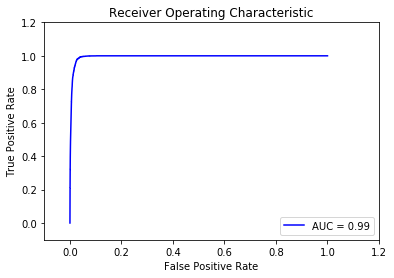

In [8]:
# use XGBOOST  as the model of the second layer
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 nthread=40,
 seed=27)


# split for validation
n = int(stacked_train.shape[0] * 0.8)
x_tra, y_tra = stacked_train[:n], y_train[:n]
x_val, y_val = stacked_train[n:], y_train[n:]
model.fit(x_tra,y_tra)
y_pred = pd.DataFrame(model.predict_proba(x_val))[1]

_f1,_f2,_f3 = atecml.data.accuracy_validation(y_val,y_pred)

In [9]:
# predict on test data
final_model = XGBClassifier(
 learning_rate =0.05,
 n_estimators=500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 scoring='roc_auc',
 nthread=40,
 seed=27)


final_model.fit(stacked_train, y_train)
test_prediction = final_model.predict_proba(stacked_test)

result=pd.DataFrame()
result['id'] = val_df['id']
result['score'] = pd.DataFrame(test_prediction)[1]
result.to_pickle('./reject_inf.dat')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18eca77208>]],
      dtype=object)

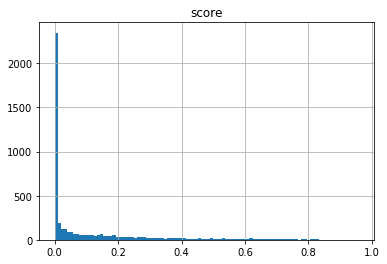

In [10]:
result.hist(bins=100)

In [20]:
len(result[result.score > 0.1])

1494

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18014ad4e0>]],
      dtype=object)

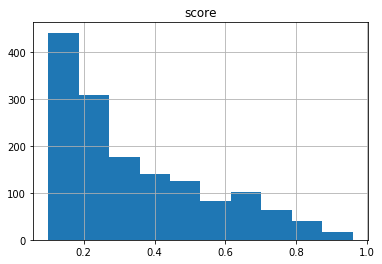

In [21]:
result[result.score > 0.1].hist()

In [13]:
result

,id,score
0,3c4b3baa09510eec473f45079c7c7977fc01fdfed93a8b...,0.000026
1,643b560780177054c375bd2ddd8a1ac6b99b728f016c75...,0.396309
2,addd09c73d0bfa3d98e252865c3343b534db2f0701e089...,0.000088
3,f8e66a38649c631bc205bd9f5cb953e214b17a3d9c80f2...,0.000001
4,61dacd672d0d12112ae4c5a9f0aa7d348c9566ba60bda3...,0.000004
5,bbd743c945e39779d7136f90dcd6e005b04d6660dd65ec...,0.195287
6,072a5f1007ec94ff4e6547783ec3dff4c72073dcfe5dfa...,0.000009
7,3842de26f717890858813543c6938c0fdb346b3e3fc715...,0.000723
8,1ac41ee380516d13d2692b74eb08e7b33135fe8b745ca8...,0.096965
9,1e06c933127058d1d88c63084522d4aa19dd0d55bc61ee...,0.384532
